# An In-depth Exploration of US Job Market by analyzing LinkedIn Job Postings using Natural Language Processing Techniques

## Data ingestion and preprocesing
We firstly need to read the webscraped dataset and explore its contents before we begin the analysis.
For a better understanding of one domain we will focus on the jobs regarding the IT industry.

In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import json
from ollama import chat
from pydantic import BaseModel, Field
from typing import List

In [26]:
# Read the dataset
data = pd.read_csv('/Users/juliabarsow/Desktop/thesis/project_code/postings.csv')

In [27]:
# Check how many descriptions are missing as this is the most important column
print("Missing rows of description: ",data['description'].isnull().sum())

# Drop rows with missing descriptions
data = data.dropna(subset=['description'])

Missing rows of description:  7


In [ ]:
# List of titles to take into account in our project
# 'Project Manager' was excluded as it contained also non-IT related job postings
titles_to_classify = [
    'Full Stack Engineer',
    'Java Architect',
    'Intern- Business Analytics',
    'Frontend Engineer',
    'Machine Learning Engineer',
    'Junior Project Manager',
    'Azure Data Engineer',
    'Sr. Project Engineer',
    'Junior Business Analyst',
    'Cloud / .NET Developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Computer Scientist',
    'DevOps Engineer',
    'Front end specialist',
    'Project Engineer',
    'Data Architect',
    'Data Analyst',
    'Java architect / Lead Java developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Senior Software Engineer',
    'Web Developer',
    'Software Implementation Program Manager',
    'Test Engineer',
    'Sr Software Engineer',
    'IT QA Engineer II',
    'Sr. Business Analyst/Tester',
    'Senior Developer – React Native',
    'Cloud DevOps Engineer',
    'Senior Analyst, Data & Analytics',
    'Senior Business Analyst',
    'Engineering Project Manager / Project Manager',
    'Java full Stack Engineer',
    'backend Java developer',
    'Data Science Software Engineer',
    'Data Engineer/ETL'
]

# Filter the dataset to include only the specified titles
data = data[data['title'].isin(titles_to_classify)].reset_index(drop=True)

<Axes: title={'center': 'Job Title Distribution'}, xlabel='title'>

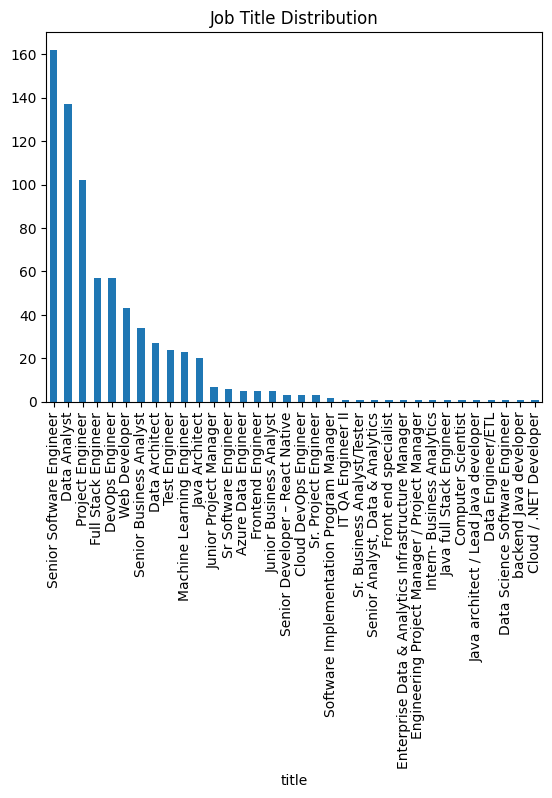

In [59]:
data['title'].value_counts().plot(kind='bar', title='Job Title Distribution')

In [60]:
# Make a copy of dataset for further processing and save only title and description columns
df = data.copy()
df = df[['title', 'description']]

In [61]:
def classify_job_titles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'general job classification' to a DataFrame based on 
    keywords found in the 'title' column.

    The classification logic applies rules in a specific order of precedence
    to handle complex or overlapping job titles.

    Args:
        df: The input pandas DataFrame containing a 'title' column.

    Returns:
        The modified DataFrame with the new 'general job classification' column.
    """
    if 'title' not in df.columns:
        print("Error: DataFrame must contain a 'title' column.")
        return df

    # Convert titles to lowercase for case-insensitive matching
    titles_lower = df['title'].str.lower().fillna('')

    # Use a function to apply classification rules with precedence
    def get_classification(title: str) -> str:
        """Determines the classification based on keywords in order of importance."""

        # 1. Project Management
        # Check for Program Manager or Project Manager/Engineer first
        if 'program manager' in title or 'project manager' in title or 'project engineer' in title:
            return 'Project Management'

        # 2. Data & Analytics (Includes specialized data engineering/ML roles)
        if ('data' in title and ('engineer' in title or 'analyst' in title or 'architect' in title)) or \
           'machine learning' in title or 'analytics' in title or 'etl' in title or 'data science' in title:
            return 'Data & Analytics'

        # 3. Business Analysis
        if 'business analyst' in title:
            return 'Business Analysis'
        
        # 4. Technical Architecture (Catch-all for non-data architects)
        if 'architect' in title:
            return 'Technical Architecture'

        # 5. Software Development / Engineering (The catch-all for core tech roles)
        if 'software engineer' in title or 'developer' in title or 'devops' in title or \
           'full stack' in title or 'web developer' in title or 'frontend' in title or \
           'test engineer' in title or 'qa engineer' in title or 'computer scientist' in title or 'front end' in title:
            return 'Software Development / Engineering'

        # Default classification
        return 'Other/Unclassified'

    # Apply the classification function to the lowercase titles
    df['general job classification'] = titles_lower.apply(get_classification)
    
    return df

In [62]:
df = classify_job_titles(df)

In [63]:
df['general job classification'].value_counts()

general job classification
Software Development / Engineering    366
Data & Analytics                      197
Project Management                    115
Business Analysis                      40
Technical Architecture                 21
Name: count, dtype: int64

## Skill Extraction and Clustering

### Objective: Extract required skills from job descriptions and cluster them to identify common skill sets across industries.

Research Questions:

- What are the most in-demand skills across different sectors?

-  How do skill requirements differ by salary range or job title?

-  What are the salary ranges in different sectors and job positions?


### We will use Ollama: https://ollama.com/ for the skill extraction

In [ ]:
# Run these commands in terminal to set up ollama and run the model
!pip install ollama
!python3 -m ollama pull llama3.2
!python3 -m ollama run granite3.2:8b

In [49]:
# Define the desired output structure using Pydantic
# This creates a JSON Schema that Ollama is forced to follow.
class JobRequirements(BaseModel):
    """A structured model to hold the extracted skills and requirements from a job posting."""
    skills: List[str] = Field(
        ..., 
        description="A list of specific, technical, or soft skills required. E.g., 'Python', 'Machine Learning', 'Problem-Solving'."
    )
    requirements: List[str] = Field(
        ..., 
        description="A list of formal requirements, like years of experience, educational degrees, or specific certifications. E.g., 'Bachelor's Degree in Computer Science', '5+ years of experience with Kafka', 'AWS Certified'."
    )

In [50]:
# Define the job posting text you want to analyze
job_posting_text = df['description'].iloc[0]

In [54]:
# Define the prompt and configuration for Ollama
def extract_skills_requirements(job_post: str, model_name: str = "llama3.2") -> JobRequirements:
    """
    Sends the job posting to an Ollama model and extracts structured data.
    """
    
    # Generate the JSON schema from the Pydantic model
    schema = JobRequirements.model_json_schema()

    # The system prompt guides the model's behavior
    system_prompt = (
        "You are an expert HR data extraction bot. Your task is to accurately "
        "extract the required skills and formal requirements from the provided job posting. "
        "Do not include any commentary or additional text. "
        "The output MUST conform strictly to the provided JSON schema."
    )
    
    # The user prompt contains the data to be analyzed
    user_prompt = f"Analyze the following job posting and return the extracted data:\n\n---\n{job_post}"
    
    print(f"--- Sending request to Ollama with model: {model_name} ---")

    try:
        response = chat(
            model=model_name,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            # This is the key setting for structured output!
            format=schema,
            # Use temperature 0 for deterministic, reliable extraction
            options={'temperature': 0}
        )
        
        # The model's content is a JSON string conforming to the schema
        json_string = response['message']['content']
        
        # Validate and convert the JSON string back into a Pydantic object
        extracted_data = JobRequirements.model_validate_json(json_string)
        
        return extracted_data

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Ensure Ollama server is running and the model is pulled.")
        return None

In [ ]:
# Execute the extraction and display the results
result = extract_skills_requirements(job_posting_text)
if result:
    print("\n--- Extracted Data (Structured Output) ---")
    print(f"Model Used: llama3")
    print("-" * 35)
    print(f"SKILLS: \n  - " + "\n  - ".join(result.skills))
    print(f"\nFORMAL REQUIREMENTS: \n  - " + "\n  - ".join(result.requirements))
    
    # Access the raw data as a dictionary
    # print("\nRaw Dictionary Output:", result.model_dump())

--- Sending request to Ollama with model: llama3.2 ---

--- Extracted Data (Structured Output) ---
Model Used: llama3
-----------------------------------
SKILLS: 
  - full-stack web development
  - JavaScript/TypeScript
  - React
  - Node.js
  - Python
  - Express.js
  - relational databases
  - NoSQL databases
  - HTML5
  - CSS3
  - responsive design principles
  - cloud platforms
  - AWS
  - Azure
  - Google Cloud Platform
  - software engineering best practices
  - version control
  - testing
  - continuous integration/continuous deployment (CI/CD) pipelines

FORMAL REQUIREMENTS: 
  - 3+ years of professional experience in software development
  - Proficiency in modern programming languages and frameworks
  - Experience with relational and NoSQL databases
  - Strong understanding of web development fundamentals
  - Familiarity with cloud platforms and services
  - Knowledge of software engineering best practices


In [55]:
# Add extracted skills and formal requirements to the DataFrame
def append_skills_requirements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts skills and formal requirements from each job description in the DataFrame
    and appends them as new columns.

    Args:
        df: The input DataFrame with a 'description' column.

    Returns:
        The modified DataFrame with 'skills' and 'formal_requirements' columns.
    """
    skills_list = []
    requirements_list = []

    for i, job_posting_text in enumerate(df['description']):
        print(f"Processing row {i + 1}/{len(df)}...")
        result = extract_skills_requirements(job_posting_text)
        if result:
            skills_list.append(result.skills)
            requirements_list.append(result.requirements)
        else:
            skills_list.append([])  # Append empty list if extraction fails
            requirements_list.append([])

    # Add the extracted data as new columns
    df['skills'] = skills_list
    df['formal_requirements'] = requirements_list

    return df

In [56]:
df_skills = append_skills_requirements(df)

Processing row 1/1093...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 2/1093...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 3/1093...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 4/1093...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 5/1093...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 6/1093...
--- Sending request to Ollama with model: llama3.2 ---


KeyboardInterrupt: 

In [ ]:
df_skills.head()

### NEXT STEPS

1. Skill Extraction - NER model for skills
Use a model trained to recognize skills (e.g., SpaCy custom NER, or libraries like SkillNer, Pyresparser, or ESCO-based tools).

2. Associate Skills with Job Titles

example:
skills_by_job = {}

for title, description in zip(job_titles, job_descriptions):
    doc = nlp(description.lower())
    tokens = [token.lemma_ for token in doc if token.lemma_ in skill_set]
    skills_by_job[title] = tokens


3. Clustering Skills into Categories - Automated clustering with embeddings (advanced)
Use word embeddings (like word2vec, spaCy, or sentence-transformers) + KMeans to group similar skills.

example:

from sklearn.cluster import KMeans
import numpy as np

--- Get unique skills
unique_skills = list(set(extracted_skills))

--- Get spaCy vector for each skill
skill_vectors = [nlp(skill).vector for skill in unique_skills]

--- Cluster with KMeans
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(skill_vectors)

--- Map each skill to its cluster
clusters = {}
for skill, label in zip(unique_skills, labels):
    clusters.setdefault(label, []).append(skill)
